In [26]:
import sys
sys.path.append('../')

import numpy as np, matplotlib.pyplot as plt
import scipy.optimize as optimize
import matplotlib as mpl
from astropy.io import ascii as asc
from astropy.table import Table
from MACT_utils import composite_errors, get_tempz, get_mainseq_fit_params

FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'
CUTOFF_SIGMA = 4.0
CUTOFF_MASS = 6.0

In [2]:
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',
    guess=False, Reader=asc.FixedWidthTwoLine)
good_sig_iis = np.where((corr_tbl['flux_sigma'] >= CUTOFF_SIGMA) & 
    (corr_tbl['stlr_mass'] >= CUTOFF_MASS))[0]
corr_tbl = corr_tbl[good_sig_iis]

filts = corr_tbl['filt'].data
sigmas = corr_tbl['meas_errs'].data
mass = corr_tbl['stlr_mass'].data
sfr = corr_tbl['met_dep_sfr'].data
dust_corr_factor = corr_tbl['dust_corr_factor'].data
filt_corr_factor = corr_tbl['filt_corr_factor'].data
nii_ha_corr_factor = corr_tbl['nii_ha_corr_factor'].data
sfrs = sfr+filt_corr_factor+nii_ha_corr_factor+dust_corr_factor

z_sp = corr_tbl['zspec0'].data
no_spectra  = np.where((z_sp <= 0) | (z_sp > 9))[0]
yes_spectra = np.where((z_sp > 0) & (z_sp < 9))[0]

tempz = get_tempz(z_sp, filts)
mz_data = np.vstack([mass, tempz]).T

n = len(good_sig_iis)

In [8]:
eqn0 = r'$\log(SFR) = \alpha \log(M) + \beta$'
def func0(data, a, b):
    return a*data + b

eqn1 = r'$\log(SFR) = \alpha \log(M) + \beta z + \gamma$'
def func1(data, a, b, c):
    return a*data[:,0] + b*data[:,1] + c

eqn2 = r'$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta$'
def func2(x, a1, a2, b):
    return np.piecewise(x, [x < m_char], [lambda x:a1*(x-m_char)+b, lambda x:a2*(x-m_char)+b])
    
eqn3 = r'$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta z + \gamma$'
def func3(x, a1, a2, b, c):
    m = x[:,0]
    z = x[:,1]
    return np.select([m < m_char, m >= m_char], [a1*(m-m_char)+b*z+c, a2*(m-m_char)+b*z+c])

eqnN = r'$\log(SFR) = S_0 - \log(1 + (\frac{10^M}{10^{M_0}})^{-\gamma}$'
def funcN(mass, gamma):
    return np.max(sfrs) - np.log10(1 + ((10**mass)/(10**8.))**(-gamma))

In [12]:
m_char_arr = np.arange(7.1,10.1,0.1)
for m_char in m_char_arr:
    def funcN(mass, gamma):
        return np.max(sfrs) - np.log10(1 + ((10**mass)/(10**m_char))**(-gamma))
    params, pcov = optimize.curve_fit(funcN, mass, sfrs)
    print params

[6.65235883]
[6.0654106]
[5.58501951]
[5.16339705]
[4.79951967]
[4.48070945]
[4.19448818]
[3.93964191]
[3.71388306]
[3.51226319]
[3.33100268]
[3.16641443]
[3.01413072]
[2.87074824]
[2.7349011]
[2.60647179]
[2.48541257]
[2.37126627]
[2.26331204]
[2.16083254]
[2.06330407]
[1.97045571]
[1.88219586]
[1.79849907]
[1.71931983]
[1.64456793]
[1.57410956]
[1.50778028]
[1.44539646]
[1.38676249]


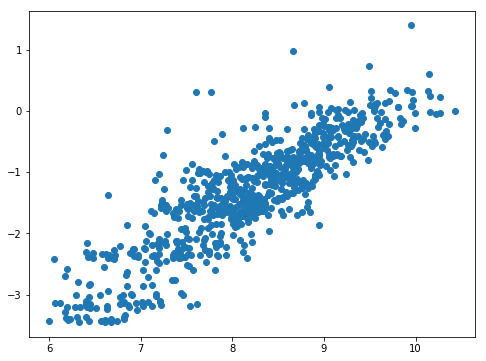

In [4]:
plt.plot(mass, sfrs, 'o')
plt.gcf().set_size_inches(8,6)
plt.show()

## fitting without piecewise functions

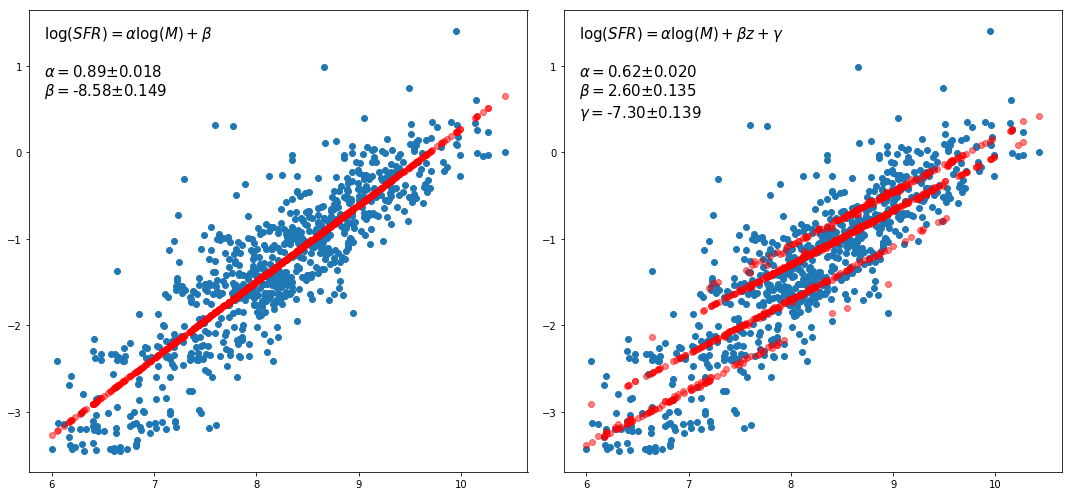

In [13]:
f, axes = plt.subplots(1,2)
# axarr = np.ndarray.flatten(axes)
f.set_size_inches(15,7)

for ax, func, eqn_str in zip(axes, [func0, func1], [eqn0, eqn1]):
    ax.plot(mass, sfrs, 'o')
    
    if 'gamma' not in eqn_str: # just a line w/o redshift dependence
        params, pcov = optimize.curve_fit(func, mass, sfrs)
        perr = np.sqrt(np.diag(pcov))
        ax.plot(mass, func(mass, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
            '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1],
            transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else: # w/ redshift dependence
        params, pcov = optimize.curve_fit(func, mz_data, sfrs)
        perr = np.sqrt(np.diag(pcov))
        ax.plot(mass, func(mz_data, *params), 'ro', alpha=0.5)
        ax.text(0.03,0.97,eqn_str+
            '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
            '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
            '\n'+r'$\gamma=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2],
            transform=ax.transAxes,fontsize=15,ha='left',va='top')


plt.tight_layout()
plt.show()

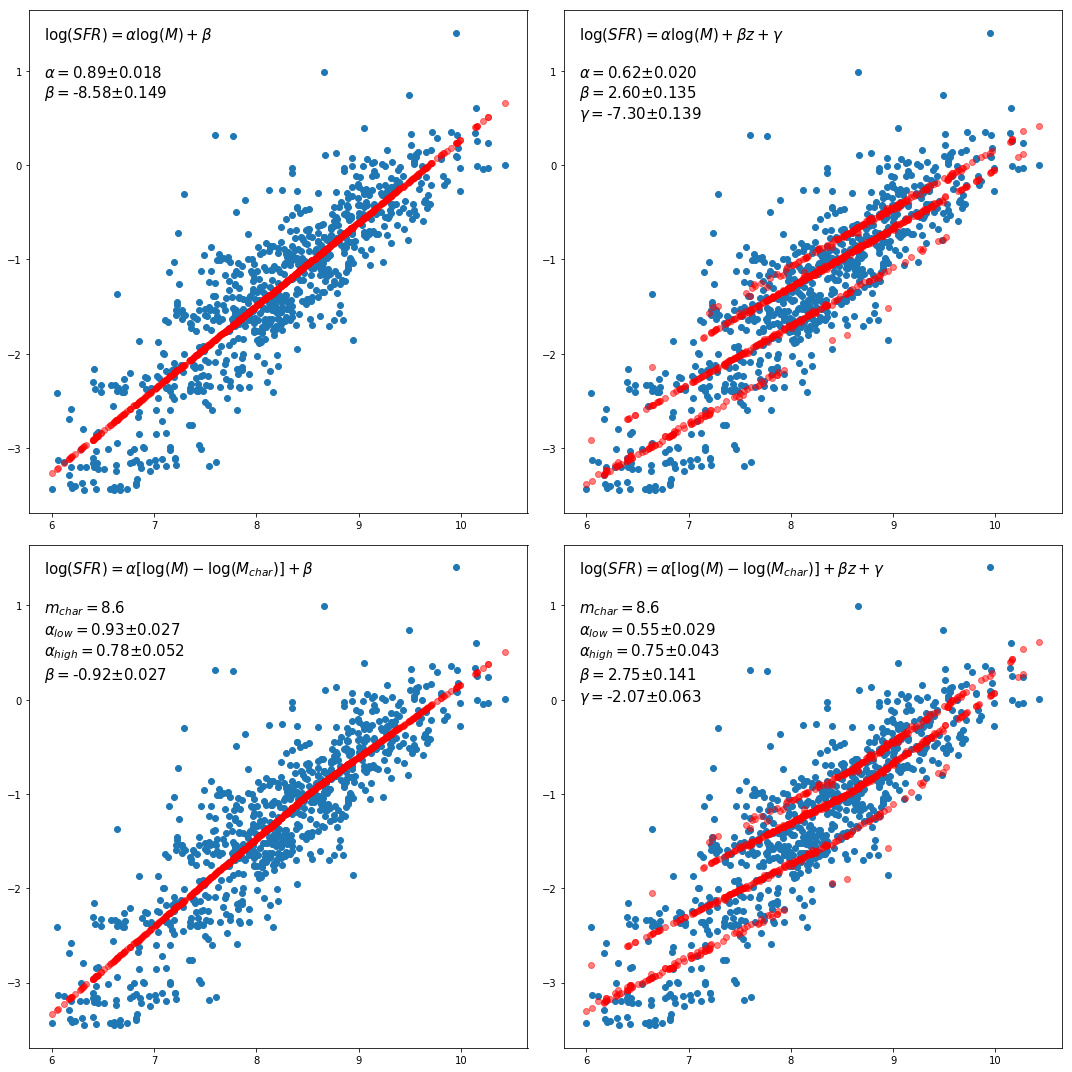

In [14]:
f, axes = plt.subplots(2,2)
axarr = np.ndarray.flatten(axes)
f.set_size_inches(15,15)

for ax, func, eqn_str in zip(axarr, [func0, func1, func2, func3], [eqn0, eqn1, eqn2, eqn3]):
    ax.plot(mass, sfrs, 'o')
    if 'char' not in eqn_str:
        if 'gamma' not in eqn_str: # just a line w/o redshift dependence
            params, pcov = optimize.curve_fit(func, mass, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mass, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')
        else: # w/ redshift dependence
            params, pcov = optimize.curve_fit(func, mz_data, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mz_data, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$\alpha=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\beta=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
                '\n'+r'$\gamma=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')
    else:
        if 'gamma' not in eqn_str:
            m_char = 8.6 # 9.1
            params, pcov = optimize.curve_fit(func, mass, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mass, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$m_{char}=$'+str(m_char)+
                '\n'+r'$\alpha_{low}=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\alpha_{high}=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
                '\n'+r'$\beta=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')
        else:
            m_char = 8.6
            params, pcov = optimize.curve_fit(func, mz_data, sfrs)
            perr = np.sqrt(np.diag(pcov))
            ax.plot(mass, func(mz_data, *params), 'ro', alpha=0.5)
            ax.text(0.03,0.97,eqn_str+
                '\n\n'+r'$m_{char}=$'+str(m_char)+
                '\n'+r'$\alpha_{low}=$'+'%.2f'%params[0]+r'$\pm$'+'%.3f'%perr[0]+
                '\n'+r'$\alpha_{high}=$'+'%.2f'%params[1]+r'$\pm$'+'%.3f'%perr[1]+
                '\n'+r'$\beta=$'+'%.2f'%params[2]+r'$\pm$'+'%.3f'%perr[2]+
                '\n'+r'$\gamma=$'+'%.2f'%params[3]+r'$\pm$'+'%.3f'%perr[3],
                transform=ax.transAxes,fontsize=15,ha='left',va='top')

plt.tight_layout()
plt.show()

$$\log(SFR) = \alpha \log(M) + \beta$$

In [102]:
k = 2 # (a,b)
nu = n - k

# params, pcov = optimize.curve_fit(func0, mass, sfrs)
params_arr = get_mainseq_fit_params(sfrs, sigmas, mass, num_params=2)
params = [np.mean(params_arr[i]) for i in range(len(params_arr))]
a = params[0]
b = params[1]
print a,b

rss = np.sum( (sfrs - func0(mass, *params))**2 )  # residual sum of squares
tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
r2 = 1 - (rss / tss)    # r-squared
r2adj = 1.0 - (n - 1.0)/(n - k - 1.0) * (1 - r2)    # adjusted r-squared
rmse = np.std((sfrs - func0(mass, *params)))      # root mean square error
old_chi2 = np.sum( (func0(mass, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
chi2 = np.sum(((sfrs - func0(mass, *params))**2)/sigmas**2)

tt = Table([[a], [b], [r2], [r2adj], [rmse], [old_chi2], [old_chi2/nu], [chi2], [chi2/nu]], 
       names=['a', 'b', r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
              'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

0.8851729029090729 -8.576332976005192


a,b,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.8851729029090729,-8.576332976005192,0.7563909032071391,0.7557614223368733,0.4396782142040434,587.8377965257201,0.7585003826138325,345681.31154710904,446.04040199626974


In [ ]:
# https://arxiv.org/pdf/1012.3754.pdf
# The first and foremost thing to do in order to assess the goodness of fit of some model to some
# data is to inspect the residuals. This is indeed trivial, because the residuals have already been
# computed in order to evaluate χ2
# (cf. Eq. (1)). For the true model having the true parameter
# values and a-priori known measurement errors, the distribution of normalised residuals (cf. Eq.
# (13)) is by definition Gaussian with mean µ = 0 and variance σ2 = 1. For any other model, this
# is not true. Consequently, all one needs to do is to plot the distribution of normalised residuals
# in a histogram and compare it to a Gaussian of µ = 0 and σ2 = 1. If the histogram exhibits
# a statistically significant deviation from the Gaussian, we can rule out that the model is the
# truth. If there is no significant difference between histogram and Gaussian, this can mean (a)
# we found the truth, or (b) we do not have enough data points to discover the deviation. The
# comparison of the residuals to this Gaussian should be objectively quantified, e.g., by using a
# Kolmogorov-Smirnov test (Kolmogorov 1933; Smirnov 1948).

KstestResult(statistic=0.055190379452330296, pvalue=0.016924731644395345)

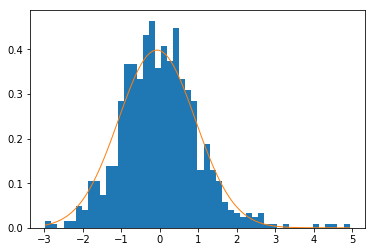

In [212]:
import scipy.stats as stats

resids = sfrs - func0(mass, *params)
std_resids = resids/np.std(resids) # standardized/normalized residuals
histfreqs = np.histogram(std_resids, bins=50)
freqs = np.column_stack((histfreqs[0], histfreqs[1][:-1]))
data = np.hstack([np.repeat(x,int(f)) for f,x in freqs])

loc, scale = stats.norm.fit(data)
n = stats.norm(loc=loc, scale=scale)

plt.hist(std_resids, bins=50, density=True)
x = np.linspace(std_resids.min(), std_resids.max(), 100)
plt.plot(x, n.pdf(x))
stats.kstest(data, n.cdf)
# smaller p value indicates more significantly the null hypothesis is to be rejected

$$\log(SFR) = \alpha \log(M) + \beta z + \gamma$$

In [17]:
k = 3 # (a,b,c)
nu = n - k

In [18]:
params, pcov = optimize.curve_fit(func1, mz_data, sfrs)
a = params[0]
b = params[1]
c = params[2]

rss = np.sum( (sfrs - func1(mz_data, *params))**2 )  # residual sum of squares
tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
r2 = 1 - (rss / tss)    # r-squared
r2adj = 1.0 - (n - 1.0)/(n - k - 1.0) * (1 - r2)    # adjusted r-squared
rmse = np.std((sfrs - func1(mz_data, *params)))      # root mean square error
old_chi2 = np.sum( (func1(mz_data, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
chi2 = np.sum(((sfrs - func1(mz_data, *params))**2)/sigmas**2)

tt = Table([[a], [b], [c], [r2], [r2adj], [rmse], [old_chi2], [old_chi2/nu], [chi2], [chi2/nu]], 
       names=['a', 'b', 'c', r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
              'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

a,b,c,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.6208112507968535,2.599065520655286,-7.297072763374217,0.8353696783184195,0.8347307508086591,0.36144574527059176,649.0822415058893,0.8386075471652317,425094.2568316265,549.2173860873728


## fitting with a piecewise powerlaw fit (no redshift dependence)

$$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta$$

In [19]:
k = 3 # (a1,a2,b)
nu = n - k

In [20]:
a_low_arr, a_high_arr, b_arr, r2_arr, r2adj_arr, rmse_arr, old_chi2_arr, chi2_arr = [],[],[],[],[],[],[],[]
m_char_arr = np.arange(8.0,10.1,0.1)

for m_char in m_char_arr:
    def piecewise_linear(x, a1, a2, b):
        return np.piecewise(x, [x < m_char], [lambda x:a1*(x-m_char)+b, lambda x:a2*(x-m_char)+b])
    
    params, pcov = optimize.curve_fit(piecewise_linear, mass, sfrs)
    a1 = params[0]
    a2 = params[1]
    b = params[2]

    a_low_arr.append('%.2f'%a1+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[0])
    a_high_arr.append('%.2f'%a2+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[1])
    b_arr.append('%.2f'%b+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[2])
    
    rss = np.sum( (sfrs - piecewise_linear(mass, *params))**2 )  # residual sum of squares
    tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
    r2 = 1 - (rss / tss)    # r-squared
    r2adj = 1.0 - (n - 1.0)/(n - k - 1.0) * (1 - r2)    # adjusted r-squared
    rmse = np.std((sfrs - piecewise_linear(mass, *params)))      # root mean square error
    old_chi2 = np.sum( (piecewise_linear(mass, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
    chi2 = np.sum(((sfrs - piecewise_linear(mass, *params))**2)/sigmas**2)

    r2_arr.append(np.around(r2,6))
    r2adj_arr.append(np.around(r2adj,6))
    rmse_arr.append(np.around(rmse,6))
    old_chi2_arr.append(np.around(old_chi2,6))
    chi2_arr.append(np.around(chi2,6))
    
tt = Table([m_char_arr, a_low_arr, a_high_arr, b_arr, r2_arr, r2adj_arr, rmse_arr, 
            old_chi2_arr, np.around(np.array(old_chi2_arr)/nu,4), chi2_arr, np.around(np.array(chi2_arr)/nu,4)], 
           names=['m'+r'$_{\rm char}$', 'a'+r'$_{\rm low}$', 'a'+r'$_{\rm high}$', 'b',  
                  r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
                  'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])

tt

m$_{\rm char}$,a$_{\rm low}$,a$_{\rm high}$,b,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,str13,str14,str14,float64,float64,float64,float64,float64,float64,float64
8.0,0.97$\pm$0.04,0.82$\pm$0.03,-1.44$\pm$0.03,0.758217,0.757278,0.438028,589.13432,0.7612,339323.596939,438.4026
8.1,0.96$\pm$0.04,0.82$\pm$0.03,-1.36$\pm$0.03,0.757987,0.757048,0.438235,588.956083,0.7609,338523.498646,437.3689
8.2,0.95$\pm$0.03,0.81$\pm$0.04,-1.27$\pm$0.03,0.757878,0.756938,0.438334,588.871061,0.7608,337318.040928,435.8114
8.299999999999999,0.94$\pm$0.03,0.80$\pm$0.04,-1.18$\pm$0.03,0.75797,0.757031,0.43825,588.943054,0.7609,335783.218497,433.8284
8.399999999999999,0.94$\pm$0.03,0.79$\pm$0.04,-1.09$\pm$0.03,0.758043,0.757104,0.438185,588.999338,0.761,334583.458643,432.2784
8.499999999999998,0.93$\pm$0.03,0.79$\pm$0.05,-1.01$\pm$0.03,0.757972,0.757033,0.438249,588.944363,0.7609,333891.338524,431.3842
8.599999999999998,0.93$\pm$0.03,0.78$\pm$0.05,-0.92$\pm$0.03,0.757907,0.756968,0.438308,588.894046,0.7608,332985.422065,430.2137
8.699999999999998,0.92$\pm$0.03,0.77$\pm$0.06,-0.83$\pm$0.03,0.757888,0.756948,0.438325,588.879003,0.7608,331760.705151,428.6314
8.799999999999997,0.92$\pm$0.02,0.75$\pm$0.06,-0.74$\pm$0.03,0.757947,0.757008,0.438272,588.924817,0.7609,330621.652638,427.1598


## fitting with a piecewise powerlaw fit (redshift dependence)

$$\log(SFR) = \alpha [\log(M) - \log(M_{char})] + \beta z + \gamma$$

In [21]:
k = 4 # (a1,a2,b,c)
nu = n-k

In [24]:
a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, old_chi2_arr, chi2_arr = [],[],[],[],[],[],[],[],[]
# m_char_arr = np.arange(6.1,10.5,0.1)
# m_char_arr = np.arange(9.0,9.6,0.1)
# m_char_arr = np.arange(7.1,10.1,0.1)
m_char_arr = np.arange(8.0,10.1,0.1)
# m_char_arr = [9.2]

for m_char in m_char_arr:
    def piecewise_linear_z(x, a1, a2, b, c):
        m = x[:,0]
        z = x[:,1]
        return np.select([m < m_char, m >= m_char], [a1*(m-m_char)+b*z+c, a2*(m-m_char)+b*z+c])
    
    guesses = (0.9, 0.5, 2.8, -1.8)
    params, pcov = optimize.curve_fit(piecewise_linear_z, mz_data, sfrs, p0=guesses)
    a1 = params[0]
    a2 = params[1]
    b = params[2]
    c = params[3]
    
    a_low_arr.append('%.2f'%a1+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[0])
    a_high_arr.append('%.2f'%a2+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[1])
    b_arr.append('%.2f'%b+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[2])
    c_arr.append('%.2f'%c+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[3])
    
    rss = np.sum( (sfrs - piecewise_linear_z(mz_data, *params))**2 )  # residual sum of squares
    tss = np.sum((sfrs - np.mean(sfrs)) ** 2)    # total sum of squares
    r2 = 1 - (rss / tss)    # r-squared
    r2adj = 1.0 - (n - 1.0)/(n - k - 1.0) * (1 - r2)    # adjusted r-squared
    rmse = np.std((sfrs - piecewise_linear_z(mz_data, *params)))      # root mean square error
    old_chi2 = np.sum( (piecewise_linear_z(mz_data, *params) - np.mean(sfrs))**2 )/np.std(sfrs)**2
    chi2 = np.sum(((sfrs - piecewise_linear_z(mz_data, *params))**2)/sigmas**2)

    r2_arr.append(np.around(r2,6))
    r2adj_arr.append(np.around(r2adj,6))
    rmse_arr.append(np.around(rmse,6))
    old_chi2_arr.append(np.around(old_chi2,4))
    chi2_arr.append(np.around(chi2,4))
    
tt = Table([m_char_arr, a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, 
            old_chi2_arr, np.around(np.array(old_chi2_arr)/nu,4), chi2_arr, np.around(np.array(chi2_arr)/nu,4)], 
           names=['m'+r'$_{\rm char}$', 'a'+r'$_{\rm low}$', 'a'+r'$_{\rm high}$', 'b', 'c',
                  r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
                  'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

m$_{\rm char}$,a$_{\rm low}$,a$_{\rm high}$,b,c,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,str13,str13,str13,str14,float64,float64,float64,float64,float64,float64,float64
8.0,0.52$\pm$0.04,0.68$\pm$0.03,2.73$\pm$0.14,-2.43$\pm$0.06,0.837413,0.836571,0.359195,650.6701,0.8417,435348.93,563.194
8.1,0.51$\pm$0.04,0.69$\pm$0.03,2.75$\pm$0.14,-2.38$\pm$0.06,0.837828,0.836987,0.358737,650.9921,0.8422,438321.5873,567.0396
8.2,0.52$\pm$0.04,0.70$\pm$0.03,2.75$\pm$0.14,-2.32$\pm$0.06,0.837985,0.837146,0.358563,651.1144,0.8423,441291.9383,570.8822
8.299999999999999,0.53$\pm$0.03,0.71$\pm$0.03,2.75$\pm$0.14,-2.26$\pm$0.06,0.837857,0.837017,0.358705,651.0149,0.8422,443172.8846,573.3155
8.399999999999999,0.54$\pm$0.03,0.72$\pm$0.04,2.75$\pm$0.14,-2.20$\pm$0.06,0.837738,0.836897,0.358837,650.9222,0.8421,444565.9129,575.1176
8.499999999999998,0.54$\pm$0.03,0.74$\pm$0.04,2.75$\pm$0.14,-2.14$\pm$0.06,0.837805,0.836965,0.358762,650.9745,0.8421,446518.69,577.6438
8.599999999999998,0.55$\pm$0.03,0.75$\pm$0.04,2.75$\pm$0.14,-2.07$\pm$0.06,0.837793,0.836953,0.358775,650.9654,0.8421,448260.8422,579.8976
8.699999999999998,0.56$\pm$0.03,0.76$\pm$0.05,2.74$\pm$0.14,-2.00$\pm$0.06,0.837624,0.836783,0.358963,650.8338,0.842,449393.3552,581.3627
8.799999999999997,0.57$\pm$0.03,0.77$\pm$0.05,2.72$\pm$0.14,-1.93$\pm$0.06,0.837242,0.836398,0.359385,650.5367,0.8416,448689.0515,580.4516


In [25]:
tt['m'+r'$_{\rm char}$'][np.argmin(tt['RMSE'])]

8.2

## fitting with a piecewise powerlaw fit (redshift dependence): looking for the knee considering only the high redshift sample

In [157]:
assert len(mass) == len(z_sp)
assert len(sfrs) == len(z_sp)
assert len(mass) == len(sfrs)

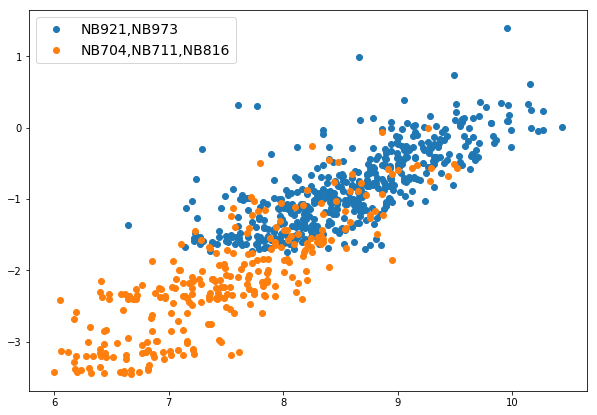

In [158]:
# [z_sp>0.3] is same as high_z = np.array([x for x in range(len(ffs)) if 'NB9' in ffs[x]])
plt.plot(mass[z_sp>0.3], sfrs[z_sp>0.3], 'o', label='NB921,NB973')
plt.plot(mass[z_sp<=0.3], sfrs[z_sp<=0.3], 'o', label='NB704,NB711,NB816')

plt.gcf().set_size_inches(10,7)
plt.legend(fontsize=14)

In [162]:
a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, old_chi2_arr, chi2_arr = [],[],[],[],[],[],[],[],[]
# m_char_arr = np.arange(6.1,10.5,0.1)
# m_char_arr = np.arange(9.0,9.6,0.1)
m_char_arr = np.arange(8.0,10.1,0.1)
# m_char_arr = [9.2]

for m_char in m_char_arr:
    def piecewise_linear_z(x, a1, a2, b, c):
        m = x[:,0]
        z = x[:,1]
        return np.select([m < m_char, m >= m_char], [a1*(m-m_char)+b*z+c, a2*(m-m_char)+b*z+c])
    
    guesses = (0.9, 0.5, 2.8, -1.8)
    params, pcov = optimize.curve_fit(piecewise_linear_z, mz_data[z_sp>0.3], sfrs[z_sp>0.3], p0=guesses)
    a1 = params[0]
    a2 = params[1]
    b = params[2]
    c = params[3]
    
    a_low_arr.append('%.2f'%a1+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[0])
    a_high_arr.append('%.2f'%a2+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[1])
    b_arr.append('%.2f'%b+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[2])
    c_arr.append('%.2f'%c+r'$\pm$'+'%.2f'%np.sqrt(np.diag(pcov))[3])
    
    rss = np.sum( (sfrs[z_sp>0.3] - piecewise_linear_z(mz_data[z_sp>0.3], *params))**2 )  # residual sum of squares
    tss = np.sum((sfrs[z_sp>0.3] - np.mean(sfrs[z_sp>0.3])) ** 2)    # total sum of squares
    r2 = 1 - (rss / tss)    # r-squared
    r2adj = 1.0 - (n - 1.0)/(n - k - 1.0) * (1 - r2)    # adjusted r-squared
    rmse = np.std((sfrs[z_sp>0.3] - piecewise_linear_z(mz_data[z_sp>0.3], *params)))      # root mean square error
    old_chi2 = np.sum( (piecewise_linear_z(mz_data[z_sp>0.3], *params) - np.mean(sfrs[z_sp>0.3]))**2 )/np.std(sfrs[z_sp>0.3])**2
    chi2 = np.sum(((sfrs[z_sp>0.3] - piecewise_linear_z(mz_data[z_sp>0.3], *params))**2)/sigmas[z_sp>0.3]**2)

    r2_arr.append(np.around(r2,6))
    r2adj_arr.append(np.around(r2adj,6))
    rmse_arr.append(np.around(rmse,6))
    old_chi2_arr.append(np.around(old_chi2,4))
    chi2_arr.append(np.around(chi2,4))
    
tt = Table([m_char_arr, a_low_arr, a_high_arr, b_arr, c_arr, r2_arr, r2adj_arr, rmse_arr, 
            old_chi2_arr, np.around(np.array(old_chi2_arr)/nu,4), chi2_arr, np.around(np.array(chi2_arr)/nu,4)], 
           names=['m'+r'$_{\rm char}$', 'a'+r'$_{\rm low}$', 'a'+r'$_{\rm high}$', 'b', 'c',
                  r'$R^2$', r'$R^2_{\rm adj}$', 'RMSE', 
                  'old '+r'$\chi^2$', 'old '+r'$\chi^2_{red}$', r'$\chi^2$', r'$\chi^2_{red}$'])
tt

m$_{\rm char}$,a$_{\rm low}$,a$_{\rm high}$,b,c,$R^2$,$R^2_{\rm adj}$,RMSE,old $\chi^2$,old $\chi^2_{red}$,$\chi^2$,$\chi^2_{red}$
float64,str14,str13,str13,str14,float64,float64,float64,float64,float64,float64,float64
8.0,-0.01$\pm$0.09,0.70$\pm$0.03,3.21$\pm$0.38,-2.68$\pm$0.16,0.657353,0.655578,0.322393,328.6766,0.4252,214832.1269,277.92
8.1,0.08$\pm$0.08,0.71$\pm$0.03,3.22$\pm$0.38,-2.63$\pm$0.16,0.657056,0.655279,0.322533,328.5281,0.425,217139.4527,280.9049
8.2,0.16$\pm$0.07,0.73$\pm$0.03,3.24$\pm$0.38,-2.59$\pm$0.16,0.656148,0.654367,0.322959,328.0742,0.4244,220053.675,284.6749
8.3,0.23$\pm$0.06,0.74$\pm$0.03,3.27$\pm$0.38,-2.54$\pm$0.16,0.654226,0.652435,0.323861,327.1132,0.4232,223567.582,289.2207
8.4,0.28$\pm$0.05,0.75$\pm$0.04,3.31$\pm$0.38,-2.50$\pm$0.16,0.652826,0.651027,0.324516,326.413,0.4223,227098.7235,293.7888
8.5,0.32$\pm$0.05,0.78$\pm$0.04,3.36$\pm$0.38,-2.47$\pm$0.16,0.652856,0.651057,0.324502,326.428,0.4223,231071.468,298.9282
8.6,0.35$\pm$0.04,0.79$\pm$0.04,3.41$\pm$0.38,-2.43$\pm$0.17,0.65176,0.649956,0.325014,325.88,0.4216,235492.1265,304.647
8.7,0.39$\pm$0.04,0.81$\pm$0.05,3.43$\pm$0.38,-2.37$\pm$0.17,0.649104,0.647286,0.326251,324.5519,0.4199,239091.7835,309.3037
8.8,0.43$\pm$0.04,0.81$\pm$0.05,3.43$\pm$0.38,-2.30$\pm$0.17,0.645303,0.643465,0.328013,322.6516,0.4174,240164.7485,310.6918


$$ f(x) = \begin{cases} 
      0 & x\leq 0 \\
      \frac{100-x}{100} & 0\leq x\leq 100 \\
      0 & 100\leq x 
   \end{cases}
$$